Title - "Predicting the Box-Office Weekend Opening Sales of Movies"

Here, we are trying to build a model which can predict the box office opening sales of upcoming movies. We anticipate that the sales will depend on factors like genre, cast actors, actresses, director, movie budget etc. 

We have scraped the data from IMDB and other movie database sources and have saved it in a .csv file. We are using this data for building our baseline and enhanced models.

After scraping, we saved the data in a format similar to pandas dataframes so that we could use pandas to read it at runtime.

Below, we are using pandas to load the data into memory. At the end of the cell, we have printed out first 5 entries of the data. Each entry of movie contains name of the movie, day/month/year of release, budget, gross collection, worldwide collection, genre, language, country, rating etc.

In [1]:
import os, sys, pandas
from datetime import datetime
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
from sklearn import metrics

pandas.set_option('display.height', 1000)
pandas.set_option('display.max_rows', 500)
pandas.set_option('display.max_columns', 500)
pandas.set_option('display.width', 1000)

t1 = datetime.now()

filepath = '/home/nkumarrai/sem_3/cse519/project/data_2/all_data_new.csv'
print (filepath)
movies_data = pandas.read_csv(filepath, encoding ='utf-8', sep='\t')
movies_data.head(2)
delta = datetime.now() - t1
print ("Total time taken ", int(delta.total_seconds()))

[a, b] = movies_data.axes
print b

#movies_data = movies_data.sort_values(['Release Year'], ascending=[False])#, inplace=True)
movies_data.head(5)

height has been deprecated.

/home/nkumarrai/sem_3/cse519/project/data_2/all_data_new.csv
('Total time taken ', 0)
Index([u'Unnamed: 0', u'Movie', u'Month', u'Day', u'Release Year', u'Budget($M)', u'Domestic Gross($M)', u'Worldwide Gross($M)', u'URL', u'Language', u'Country', u'Genre', u'CastID', u'Rating', u'DirectorID'], dtype='object')


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,Unnamed: 0,Movie,Month,Day,Release Year,Budget($M),Domestic Gross($M),Worldwide Gross($M),URL,Language,Country,Genre,CastID,Rating,DirectorID
0,0,Avatar,Dec,18,2009,425.0,760.507625,2783.918982,/title/tt0417299/?ref_=fn_al_tt_1,['English'],['USA'],[],"['', '', '', '', '', '', '', '', '', '']",NaN,NaN
1,1,Star Wars Ep. VII: The Force Awakens,Dec,18,2015,306.0,936.662225,2058.662225,/title/tt6524062/?ref_=fn_al_tt_1,[],[],['Talk-Show'],"['', '', '', '', '', '', '', '', '', '']",7.1,nm0893659
2,2,Pirates of the Caribbean: At World's End,May,24,2007,300.0,309.420425,963.420425,/title/tt0449088/?ref_=fn_al_tt_1,['English'],['USA'],"['Action', 'Adventure', 'Fantasy']","['nm0000136/', 'nm0001691/', 'nm0089217/', 'nm...",6.8,nm0005222
3,3,Spectre,Nov,6,2015,300.0,200.074175,879.620923,/title/tt2379713/?ref_=fn_al_tt_1,"['English', 'Spanish', 'Italian', 'German', 'F...","['UK', 'USA']","['Action', 'Adventure', 'Thriller']","['nm0185819/', 'nm0910607/', 'nm2244205/', 'nm...",8.4,nm0634240
4,4,The Dark Knight Rises,Jul,20,2012,275.0,448.139099,1084.439099,/title/tt1345836/?ref_=fn_al_tt_1,"['English', 'Arabic']","['UK', 'USA']","['Action', 'Thriller']","['nm0000288/', 'nm0000198/', 'nm0362766/', 'nm...",6.5,nm0893659


Separate the dataset in two parts, train and test dataset.

Train dataset - 80%
Test dataset - 20%

In [2]:
total_length = len(movies_data)
train_len = int(0.8 * len(movies_data))
test_len = total_length - train_len

source_movies_data = movies_data.iloc[0:train_len]
target_movies = movies_data.iloc[train_len:]

print("Length of training data", len(source_movies_data))
print("Length of test data", len(target_movies))

('Length of training data', 4061)
('Length of test data', 1016)


The following function "extract_features" extracts string features with unicode representation. The scraped data from online database didn't have the data about language, country, genre in a readable format.

We are using regex to parse the string and find meaningful data out of the expression.

In [3]:
def extract_features(target_movie):
    features = []
    try:
        movie_genre = list(target_movie['Genre'])
        movie_genre = re.findall(r"'(.*?)'", movie_genre[0], re.DOTALL)
        features.append(movie_genre)
    except TypeError:
        features.append(['Adventure'])
    
    try:
        language = list(target_movie['Language'])
        language = re.findall(r"'(.*?)'", language[0], re.DOTALL)
        features.append(language)
    except TypeError:
        features.append(['English'])
        
    try:
        country = list(target_movie['Country'])
        country = re.findall(r"'(.*?)'", country[0], re.DOTALL)
        features.append(country)
    except TypeError:
        features.append(['USA'])
        
    return features

target_movie_features_list = []
for i in range(len(target_movies)):
    target_movie_features = extract_features(target_movies.iloc[[i]])
    target_movie_features_list.append(target_movie_features)

In [4]:
# Get the y_test_true values which are the domestic gross values
y_test_true = target_movies['Domestic Gross($M)']

# Get an average domestic gross values of all the movies. This value is used as replacement value when either
# there is no feature extracted or missing values. 
average_domestic_gross = movies_data['Domestic Gross($M)'].mean()

print "Average domestic gross value", average_domestic_gross

Average domestic gross value 40.4092583205


Baseline model - “average gross of all the movies grouped by features”

Till now, we have extracted some basic features which is basically 'genre', 'language' and 'country'. 

In the baseline model, we are trying to find out similar movies from the database based on the extracted features. Then, we take an average of the collection of all those movies. The average value is our prediction of the baseline model.

Here, we are creating 4 models, each model is based on one of the features mentioned above. The 4th model is based on the combination of all 3 features. 

In [5]:
def find_similar_movies_using_country(target_movie_features, source_movies_data):
    collection = []
    for i in range(source_movies_data.shape[0]):
        tmp_source_movie = source_movies_data.iloc[[i]]
        tmp_source_movie_extracted_features = extract_features(tmp_source_movie)
        tmp_set_intersection = set(target_movie_features[2]) == set(tmp_source_movie_extracted_features[2])
        if tmp_set_intersection == True:
            collection.append(float(tmp_source_movie['Domestic Gross($M)']))
    return collection

def find_similar_movies_using_language(target_movie_features, source_movies_data):
    collection = []
    for i in range(source_movies_data.shape[0]):
        tmp_source_movie = source_movies_data.iloc[[i]]
        tmp_source_movie_extracted_features = extract_features(tmp_source_movie)
        tmp_set_intersection = set(target_movie_features[1]) == set(tmp_source_movie_extracted_features[1])
        if tmp_set_intersection == True:
            collection.append(float(tmp_source_movie['Domestic Gross($M)']))
    return collection

def find_similar_movies_using_genre(target_movie_features, source_movies_data):
    collection = []
    for i in range(source_movies_data.shape[0]):
        tmp_source_movie = source_movies_data.iloc[[i]]
        tmp_source_movie_extracted_features = extract_features(tmp_source_movie)
        tmp_set_intersection = set(target_movie_features[0]) == set(tmp_source_movie_extracted_features[0])
        if tmp_set_intersection == True:
            collection.append(float(tmp_source_movie['Domestic Gross($M)']))
    return collection

    
def find_similar_movies_using_genre_country_language(target_movie_features, source_movies_data):
    collection = []
    for i in range(source_movies_data.shape[0]):
        tmp_source_movie = source_movies_data.iloc[[i]]
        tmp_source_movie_extracted_features = extract_features(tmp_source_movie)
        tmp_set_intersection_genre = set(target_movie_features[0]) == set(tmp_source_movie_extracted_features[0])
        tmp_set_intersection_country = set(target_movie_features[2]) == set(tmp_source_movie_extracted_features[2])
        tmp_set_intersection_language = set(target_movie_features[1]) == set(tmp_source_movie_extracted_features[1])
        if tmp_set_intersection_genre & tmp_set_intersection_country & tmp_set_intersection_language:
            collection.append(float(tmp_source_movie['Domestic Gross($M)']))
    return collection

In [6]:
loss = []

#-----1------
collection_list = []
for i in range(len(target_movie_features_list)):
    target_movie_features = target_movie_features_list[i]
    collection = find_similar_movies_using_country(target_movie_features, source_movies_data)
    if len(collection) != 0:
        collection_list.append(sum(collection)/len(collection))
    else:
        # Couldn't find any entries based on the features extracted. Fill the entry with average domestic gross value.
        collection_list.append(average_domestic_gross)
print "Complete - prediction (based on country)"

Complete - prediction (based on country)


In [7]:
tmp_loss = metrics.mean_squared_error(y_test_true, collection_list)
print "loss from the prediction of the collection of movie based on country", tmp_loss
loss.append(tmp_loss)

loss from the prediction of the collection of movie based on country 2209.57688218


In [8]:
#-----2------
collection_list = []
for i in range(len(target_movie_features_list)):
    target_movie_features = target_movie_features_list[i]
    collection = find_similar_movies_using_language(target_movie_features, source_movies_data)
    if len(collection) != 0:
        collection_list.append(sum(collection)/len(collection))
    else:
        # Couldn't find any entries based on the features extracted. Fill the entry with average domestic gross value.
        collection_list.append(average_domestic_gross)
print "Complete - prediction (based on language)"

Complete - prediction (based on language)


In [9]:
tmp_loss = metrics.mean_squared_error(y_test_true, collection_list)
print "loss from the prediction of the collection of movie based on language", tmp_loss
loss.append(tmp_loss)

loss from the prediction of the collection of movie based on language 1985.75300328


In [10]:
#-----3------
collection_list = []
for i in range(len(target_movie_features_list)):
    target_movie_features = target_movie_features_list[i]
    collection = find_similar_movies_using_genre(target_movie_features, source_movies_data)
    if len(collection) != 0:
        collection_list.append(sum(collection)/len(collection))
    else:
        # Couldn't find any entries based on the features extracted. Fill the entry with average domestic gross value.
        collection_list.append(average_domestic_gross)
print "Complete - prediction (based on genre)"

Complete - prediction (based on genre)


In [11]:
tmp_loss = metrics.mean_squared_error(y_test_true, collection_list)
print "loss from the prediction of the collection of movie based on genre", tmp_loss
loss.append(tmp_loss)

loss from the prediction of the collection of movie based on genre 1671.01076743


In [12]:
#-----4------
collection_list = []
for i in range(len(target_movie_features_list)):
    target_movie_features = target_movie_features_list[i]
    collection = find_similar_movies_using_genre_country_language(target_movie_features, source_movies_data)
    if len(collection) != 0:
        collection_list.append(sum(collection)/len(collection))
    else:
        # Couldn't find any entries based on the features extracted. Fill the entry with average domestic gross value.
        collection_list.append(average_domestic_gross)
print "Complete - prediction (based on country, genre and language)"

Complete - prediction (based on country, genre and language)


In [13]:
tmp_loss = metrics.mean_squared_error(y_test_true, collection_list)
print "loss from the prediction of the collection of movie based on genre, country, language", tmp_loss
loss.append(tmp_loss)

loss from the prediction of the collection of movie based on genre, country, language 1713.6729084


Out of the four baseline models, the model based on 'genre' outperformed. The model based on the combination of all 3 features outputs a comparable loss. However, the models are still pretty bad.

In the below cell, we do some pre-processing with data for e.g. filling NA and zero values.

In [14]:
#Fix value of zeros
source_movies_data.loc[:, 'Domestic Gross($M)'] = source_movies_data.loc[:, 'Domestic Gross($M)'].replace(to_replace=0.0, value=source_movies_data.loc[:, 'Domestic Gross($M)'].astype('float32').mean())
source_movies_data.loc[:, 'Domestic Gross($M)'] = source_movies_data.loc[:, 'Domestic Gross($M)'].fillna(source_movies_data.loc[:, 'Domestic Gross($M)'].astype('float32').mean())

source_movies_data.loc[:, 'Worldwide Gross($M)'] = source_movies_data.loc[:, 'Worldwide Gross($M)'].replace(to_replace=0.0, value=source_movies_data.loc[:, 'Worldwide Gross($M)'].astype('float32').mean())
source_movies_data.loc[:, 'Worldwide Gross($M)'] = source_movies_data.loc[:, 'Worldwide Gross($M)'].fillna(source_movies_data.loc[:, 'Worldwide Gross($M)'].astype('float32').mean())

source_movies_data.loc[:, 'Budget($M)'] = source_movies_data.loc[:, 'Budget($M)'].replace(to_replace=0.0, value=source_movies_data.loc[:, 'Budget($M)'].astype('float32').mean())
source_movies_data.loc[:, 'Budget($M)'] = source_movies_data.loc[:, 'Budget($M)'].fillna(source_movies_data.loc[:, 'Budget($M)'].astype('float32').mean())

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Here, we have created a linear regression model to predict the collection based on three features as follows - 'Budget', 'Worldwide Gross', 'Release Year'.

The data preprocessing was completed in the previous cell.

Our target value is the Domestic Gross in Millions.

In the next few steps, we created another linear regression model using 'genre', 'country' and 'language' as three more features. 

In [18]:
#########################################################
# Linear Regression
#########################################################
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
from sklearn import metrics

# Data preprocessing - it is called as data cleaning which includes -
# 1) ignoring/filling out missing values
# 2) fixing/changing formats
# 3) remove any outliers
# 4) ignore the variables

feature_names = ['Budget($M)', 'Worldwide Gross($M)', 'Release Year']

linear_reg = LinearRegression()
X_train = source_movies_data[feature_names]
linear_reg.fit(X_train, source_movies_data['Domestic Gross($M)'])
linear_reg.score(X_train, source_movies_data['Domestic Gross($M)'])

X_test = target_movies[feature_names]
    
Y_pred = linear_reg.predict(X_test)

tmp_loss = metrics.mean_squared_error(y_test_true, Y_pred)
print "loss from the prediction of the collection of movie based on linear regression using above features", tmp_loss
loss.append(tmp_loss)

loss from the prediction of the collection of movie based on linear regression using above features 223.129695809


We know that genres, languages, countries are categorical variables. So, we have tried to find out the different categories for all the variables.

We have used this information to create the new variables below.

In [19]:
#Find out all different type of genres. 

list_glc = [[],[],[]]
for i in range(source_movies_data.shape[0]):
    genres_language_country = extract_features(source_movies_data.iloc[[i]])
    tmp_genres = set(genres_language_country[0]) - set(list_glc[0])
    list_glc[0] = list(set(list_glc[0]) | set(tmp_genres))

    tmp_language = set(genres_language_country[1]) - set(list_glc[1])
    list_glc[1] = list(set(list_glc[1]) | set(tmp_language))
    
    tmp_language = set(genres_language_country[2]) - set(list_glc[2])
    list_glc[2] = list(set(list_glc[2]) | set(tmp_language))

print "Different type of genres - ", list_glc[0], "\n"
print "Different type of languages - ", list_glc[1], "\n"
print "Different type of countries - ", list_glc[2], "\n"

Different type of genres -  [u'Mystery', u'Short', u'Sci-Fi', u'Talk-Show', u'Crime', u'Romance', u'Animation', u'Music', u'Action', u'Game-Show', u'Comedy', u'Documentary', u'War', u'History', u'Drama', u'Biography', u'Family', u'Horror', u'Musical', u'Fantasy', u'Adventure', u'News', u'Sport', u'Reality-TV', u'Thriller', u'Western'] 

Different type of languages -  [u'', u'Swahili', u'Japa', u'Icelandic', u'Estonian', u'Telugu', u'Turkish', u'Zulu', u'Gujarati', u'Hindi', u'Mandarin', u'Korean', u'Nyanja', u'Shanghainese', u'Cornish', u'Bulgarian', u'Maori', u'Sindarin', u'Luxembourgish', u'Wolof', u'Bosnian', u'Bambara', u'Greenlandic', u'French', u'Quenya', u'Catalan', u'Aboriginal', u'Acholi', u'Bengali', u'Hokkien', u'Romany', u'Croatian', u'Tamil', u'Armenian', u'Mohawk', u'Nepali', u'Finnish', u'Pushto', u'Albanian', u'Panjabi', u'N', u'Russian', u'Tagalog', u'Serbian', u'Malayalam', u'Italian', u'Irish', u'Afrikaans', u'Sicilian', u'Gr', u'Amer', u'German', u'Kazakh', u'Galleg

Here, we have used the functions created previously to extract the values of genres, language and country because of the format of the data. 

New variables are the summation of the indexes of the category found in the above generated lists. 

Next, we have merged the new variables with the data.

Similar steps we have repeated for the target movies as well.

In [20]:
new_data = {}
new_data['Unnamed: 0'] = source_movies_data['Unnamed: 0']
new_data['genre_v'] = []
new_data['language_v'] = []
new_data['country_v'] = []
for i in range(source_movies_data.shape[0]):
    tmp_source = source_movies_data.iloc[[i]]
    genres_language_country = extract_features(tmp_source)
    
    sum = 0
    for j in range(len(genres_language_country[0])):
        index = list_glc[0].index(genres_language_country[0][j])
        sum = sum + index + 1
    new_data['genre_v'].append(sum)

    sum = 0
    for j in range(len(genres_language_country[1])):
        index = list_glc[1].index(genres_language_country[1][j])
        sum = sum + index + 1
    new_data['language_v'].append(sum)
        
    sum = 0
    for j in range(len(genres_language_country[2])):
        index = list_glc[2].index(genres_language_country[2][j])
        sum = sum + index + 1
    new_data['country_v'].append(sum)

new_data = pandas.DataFrame(new_data)
updated_source_movies_data = pandas.merge(source_movies_data, new_data, on='Unnamed: 0')

Generate the new variables for the target movies as well.

In [21]:
new_data = {}
new_data['Unnamed: 0'] = target_movies['Unnamed: 0']
new_data['genre_v'] = []
new_data['language_v'] = []
new_data['country_v'] = []
for i in range(target_movies.shape[0]):
    tmp_source = target_movies.iloc[[i]]
    genres_language_country = extract_features(tmp_source)
    
    sum = 0
    for j in range(len(genres_language_country[0])):
        try:
            index = list_glc[0].index(genres_language_country[0][j])
            sum = sum + index + 1
        except:
            pass
    new_data['genre_v'].append(sum)

    sum = 0
    for j in range(len(genres_language_country[1])):
        try:
            index = list_glc[1].index(genres_language_country[1][j])
            sum = sum + index + 1
        except:
            pass
    new_data['language_v'].append(sum)
        
    sum = 0
    for j in range(len(genres_language_country[2])):
        try:
            index = list_glc[2].index(genres_language_country[2][j])
            sum = sum + index + 1
        except:
            pass
    new_data['country_v'].append(sum)

new_data = pandas.DataFrame(new_data)
updated_target_movies = pandas.merge(target_movies, new_data, on='Unnamed: 0')
y_test_true = updated_target_movies['Domestic Gross($M)']

Here, we have applied the linear regression with the old variables + new variables which contain 'genre_v', 'language_v', 'country_v'.

In [22]:
#########################################################
# Linear Regression - part #2
#########################################################
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
from sklearn import metrics

# Data preprocessing - it is called as data cleaning which includes -
# 1) ignoring/filling out missing values
# 2) fixing/changing formats
# 3) remove any outliers
# 4) ignore the variables

feature_names = ['Budget($M)', 'Worldwide Gross($M)', 'Release Year', 'genre_v', 'language_v', 'country_v']

linear_reg = LinearRegression()
X_train = updated_source_movies_data[feature_names]
linear_reg.fit(X_train, updated_source_movies_data['Domestic Gross($M)'])
linear_reg.score(X_train, updated_source_movies_data['Domestic Gross($M)'])

X_test = updated_target_movies[feature_names]
    
Y_pred_lr2 = linear_reg.predict(X_test)

tmp_loss = metrics.mean_squared_error(y_test_true, Y_pred_lr2)
print "loss from the prediction of the collection of movie based on linear regression #2 using above features", tmp_loss
loss.append(tmp_loss)

loss from the prediction of the collection of movie based on linear regression #2 using above features 225.262629332


Decision Tree model

In [57]:
from sklearn.tree import DecisionTreeRegressor

feature_names = ['Budget($M)', 'Worldwide Gross($M)', 'Release Year', 'genre_v', 'language_v', 'country_v']

X_train = updated_source_movies_data[feature_names]
y_train = list(updated_source_movies_data['Domestic Gross($M)'])
X_test = updated_target_movies[feature_names]
    
estimator = DecisionTreeRegressor(max_leaf_nodes=30, random_state=0)
estimator.fit(X_train, y_train)
Y_pred_dreg = estimator.predict(X_test)

tmp_loss = metrics.mean_squared_error(y_test_true, Y_pred_dreg)
print "loss from the prediction of the collection of movie based on decision tree regressor", tmp_loss
loss.append(tmp_loss)

loss from the prediction of the collection of movie based on decision tree regressor 73.4037412489
73.4037412489


Support vector regressor model

Kernels used - 'RBF', 'SVR', 'Linear', 'Sigmoid'

In [24]:
from sklearn.svm import SVR

#-----SVR (RBF kernel)-----
clf = SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto', 
          kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
clf.fit(X_train, y_train)
Y_pred_svr_rbf = clf.predict(X_test)

tmp_loss = metrics.mean_squared_error(y_test_true, Y_pred_svr_rbf)
print "loss from the prediction of the collection of movie based on support vector regressor (rbf kernel)", tmp_loss
loss.append(tmp_loss)

#-----SVR (sigmoid kernel)-----
clf = SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto', 
          kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
clf.fit(X_train, y_train)
Y_pred_svr_sigmoid = clf.predict(X_test)

tmp_loss = metrics.mean_squared_error(y_test_true, Y_pred_svr_sigmoid)
print "loss from the prediction of the collection of movie based on support vector regressor (sigmoid kernel)", tmp_loss
loss.append(tmp_loss)

#-----SVR (linear kernel)-----
clf = SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='auto', 
          kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
clf.fit(X_train, y_train)
Y_pred_svr_linear = clf.predict(X_test)

tmp_loss = metrics.mean_squared_error(y_test_true, Y_pred_svr_linear)
print "loss from the prediction of the collection of movie based on support vector regressor (linear kernel)", tmp_loss
loss.append(tmp_loss)

#-----SVR (poly kernel)-----
clf = SVR(C=1.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.2, gamma='auto', 
          kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
clf.fit(X_train, y_train)
Y_pred_svr_poly = clf.predict(X_test)

tmp_loss = metrics.mean_squared_error(y_test_true, Y_pred_svr_poly)
print "loss from the prediction of the collection of movie based on support vector regressor (poly kernel)", tmp_loss
loss.append(tmp_loss)

loss from the prediction of the collection of movie based on support vector regressor (rbf kernel) 952.946411054
loss from the prediction of the collection of movie based on support vector regressor (sigmoid kernel) 953.674408829
loss from the prediction of the collection of movie based on support vector regressor (linear kernel) 115.001196689
loss from the prediction of the collection of movie based on support vector regressor (poly kernel) 4286140490.77


Index([u'Budget($M)', u'Domestic Gross($M)', u'Worldwide Gross($M)', u'Release Year', u'country_v', u'genre_v', u'language_v'], dtype='object')
(7, 7)


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


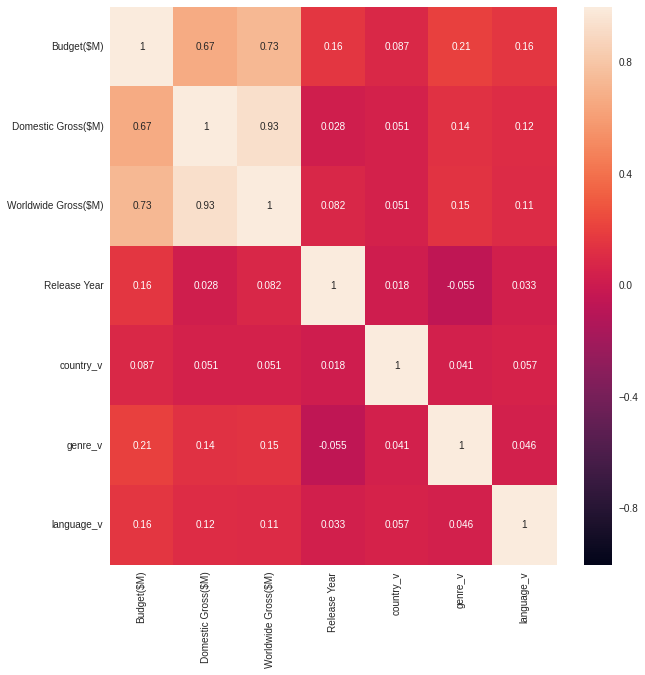

In [25]:
# Concat the training data and the test data. Use it to perform some operations to gather insight about 
# different features and how they are related to each other.

frames = [updated_source_movies_data, updated_target_movies]
updated_movies_all = pandas.concat(frames)

partial_data = updated_movies_all[['Budget($M)', 'Domestic Gross($M)', 'Worldwide Gross($M)', 'Release Year', 
                           'country_v', 'genre_v', 'language_v']]
[a, b] = partial_data.axes
print b

# Run pearson correlation method among all the columns
corr = partial_data.corr(method='pearson', min_periods=1)
print corr.shape
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr, vmin=-1, vmax=1, annot=True)

4061
1016
11


([<matplotlib.axis.XTick at 0x7fcb7c7a7d10>,
 <a list of 11 Text xticklabel objects>)

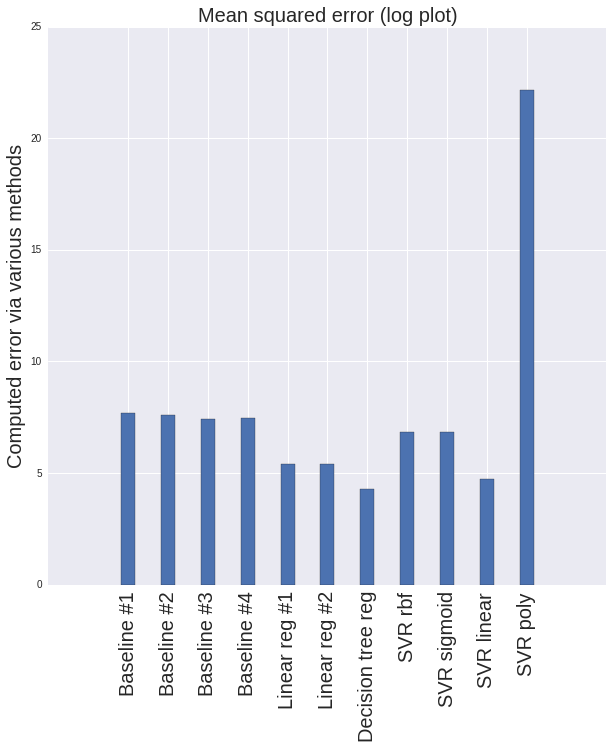

In [58]:
# updated_source_movies_data
print(len(updated_source_movies_data))
print(len(updated_target_movies))
print(len(loss))

import seaborn as sns; sns.set(color_codes=True)

fig, ax = plt.subplots(figsize=(10,10)) 
x = range(len(loss))
plt.bar(x, np.log(loss), 0.35, align="center")
plt.title("Mean squared error (log plot)", fontsize=20)
plt.ylabel("Computed error via various methods", fontsize=20)
my_xticks = ['Baseline #1', 'Baseline #2', 'Baseline #3', 'Baseline #4', "Linear reg #1", "Linear reg #2",
            'Decision tree reg', 'SVR rbf', 'SVR sigmoid', 'SVR linear', 'SVR poly']
plt.xticks(x, my_xticks, rotation='vertical', fontsize=20)

1016
1016


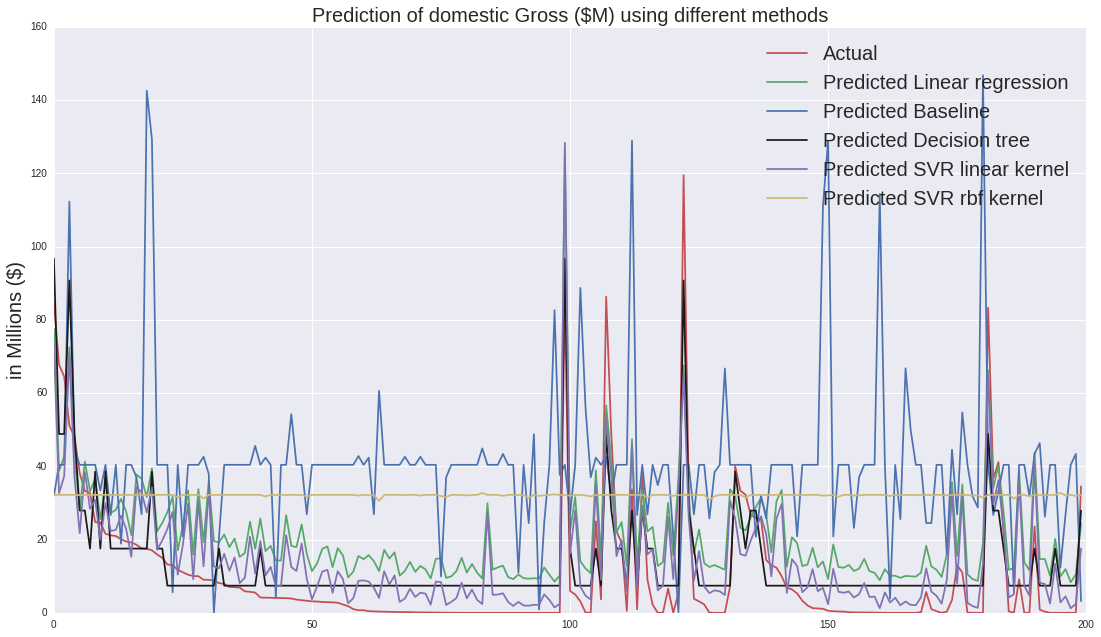

In [59]:
print(len(y_test_true))
print(len(Y_pred))

n = 200
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
x = range(len(y_test_true))
plt.plot(x[:n], y_test_true[:n], 'r')
plt.plot(x[:n], Y_pred_lr2[:n], 'g')
plt.plot(x[:n], collection_list[:n], 'b')
plt.plot(x[:n], Y_pred_dreg[:n], 'k')
plt.plot(x[:n], Y_pred_svr_linear[:n], 'm')
plt.plot(x[:n], Y_pred_svr_rbf[:n], 'y')
plt.plot()
plt.title('Prediction of domestic Gross ($M) using different methods', fontsize=20)
plt.ylabel('in Millions ($)', fontsize=20)
plt.legend(['Actual', 'Predicted Linear regression', 'Predicted Baseline', 'Predicted Decision tree', 
            'Predicted SVR linear kernel', 'Predicted SVR rbf kernel'], prop={'size': 20}, loc='upper right')